In [ ]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tripyview as tpv
import math
from cmocean import cm as cmo
import matplotlib.path as mpath
import cartopy.crs as ccrs
import matplotlib.tri as mtri
import pyfesom2 as pf

In [2]:
figpath='/PATH/TO/OUTPUT/'
datapath='/PATH/TO/DATA/'
meshpath='/PATH/TO/MESH/'

In [3]:
def simple_plot(dpi=300,
                ygridlocs=[-80,-75,-70,-65,-60],
                figsize=(6,6),
                box=[-180,180,-80,-60],
                cols=1,
                rows=1,
               ):
    
    fig, axes = plt.subplots(
                rows,cols,
                subplot_kw=dict(projection=ccrs.SouthPolarStereo()),
                constrained_layout=True,
                figsize=figsize,
                dpi=dpi,
                # facecolor='lightgrey',
            )
    if isinstance(axes, np.ndarray):
        axesflat = axes.flatten()
    else:
        axesflat = [axesflat]
    for ax in axesflat:
        ax.set_extent(box, crs=ccrs.PlateCarree())
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.505], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, \
                xlocs=range(-180,171,30), ylocs=[], \
                color='gray', alpha=0.5, linestyle='--', zorder=10)
        # Draw concentric circles (but hide labels) for the parallels of the latitude
        ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, \
                        xlocs=[], ylocs=ygridlocs, \
                        color='grey', alpha=0.5, linestyle='--', zorder=10)

        # ax.coastlines(lw=0.5, resolution="110m", facecolor='k',zorder=101)

    return fig, axes

In [4]:
# colormaps. remove dark bits
rm = cmo.tools.crop_by_percent(cmo.amp, 20, which='max', N=None)
rbm = cmo.tools.crop_by_percent(cmo.balance, 20, which='both', N=None)

In [ ]:
#for land mask
mesh=tpv.load_mesh_fesom2(meshpath, do_rot='None', focus=0, do_info=False, do_pickle=False,
                          do_earea=False, do_narea=False, do_eresol=[False,'mean'], do_nresol=[False,'eresol'])


In [ ]:
#prepare ice data in cdo

In [ ]:
%%writefile ice_calcs.sh
module load cdo

datapath=/PATH/TO/DATA

#ymonmean for spatial fields
cdo ymonmean -copy [ $datapath/a_ice.fesom.1951.nc $datapath/a_ice.fesom.1952.nc $datapath/a_ice.fesom.1953.nc \
$datapath/a_ice.fesom.1954.nc $datapath/a_ice.fesom.1955.nc $datapath/a_ice.fesom.1956.nc ] \
$datapath/a_ice_ymonmean_1951-1956.nc &

cdo ymonmean -copy [ $datapath/a_ice.fesom.2091.nc $datapath/a_ice.fesom.2092.nc $datapath/a_ice.fesom.2093.nc \
$datapath/a_ice.fesom.2094.nc $datapath/a_ice.fesom.2095.nc $datapath/a_ice.fesom.2096.nc ] \
$datapath/a_ice_ymonmean_2091-2096.nc &

#monmean for climatology
cdo monmean -copy [ $datapath/a_ice.fesom.1951.nc $datapath/a_ice.fesom.1952.nc $datapath/a_ice.fesom.1953.nc \
$datapath/a_ice.fesom.1954.nc $datapath/a_ice.fesom.1955.nc $datapath/a_ice.fesom.1956.nc ] \
$datapath/a_ice_monmean_1951-1956.nc &

cdo monmean -copy [ $datapath/a_ice.fesom.2091.nc $datapath/a_ice.fesom.2092.nc $datapath/a_ice.fesom.2093.nc \
$datapath/a_ice.fesom.2094.nc $datapath/a_ice.fesom.2095.nc $datapath/a_ice.fesom.2096.nc ] \
$datapath/a_ice_monmean_2091-2096.nc &

In [ ]:
!bash ice_calcs.sh
!rm ice_calcs.sh

In [28]:
#get node area weights from mesh
meshdiag=xr.open_dataset(meshpath+'fesom.mesh.diag.nc',chunks='auto')

inds=[x for x,y in enumerate(mesh.n_y) if y<-60]

nodarsel=meshdiag.nod_area.isel({'nz':0,'nod2':inds})
nodw=xr.DataArray(nodarsel,dims='x')

In [37]:
#climatological monthly mean ice concentration weighted by cell area 
iceclim90=xr.open_dataset(datapath+'a_ice_ymonmean_2091-2096.nc',chunks='auto').a_ice
iceclim50=xr.open_dataset(datapath+'a_ice_ymonmean_1951-1956.nc',chunks='auto').a_ice

icemean90=iceclim90.isel({'x':inds}).weighted(nodw).mean(dim='x').compute()
icemean50=iceclim50.isel({'x':inds}).weighted(nodw).mean(dim='x').compute()

In [30]:
#monthly ice concentration weighted by cell area
ice90=xr.open_dataset(datapath+'a_ice_monmean_2091-2096.nc',chunks='auto').a_ice.isel({'x':inds}).weighted(nodw).mean(dim='x').compute()
ice50=xr.open_dataset(datapath+'a_ice_monmean_1951-1956.nc',chunks='auto').a_ice.isel({'x':inds}).weighted(nodw).mean(dim='x').compute()

In [31]:
#climatological monthly min and max
ice_stack_50=[]
ice_stack_90=[]
for year in np.arange(6):
    ice_stack_50.append(ice50.sel({'time':ice50.time.dt.year==1951+year}))
    ice_stack_90.append(ice90.sel({'time':ice90.time.dt.year==2091+year}))

ice_stack_50=np.vstack(ice_stack_50)
ice_stack_90=np.vstack(ice_stack_90)

icemin50=np.min(ice_stack_50,axis=0)
icemin90=np.min(ice_stack_90,axis=0)

icemax50=np.max(ice_stack_50,axis=0)
icemax90=np.max(ice_stack_90,axis=0)

In [ ]:
#interpolate to reg grid

In [ ]:
#interpolate 2d field
so3=pf.load_mesh(meshpath)

model_lons=so3.x2
model_lats=so3.y2

elements=so3.elem.astype('int32')

d = model_lons[elements].max(axis=1) - model_lons[elements].min(axis=1)
no_cyclic_elem = np.argwhere(d < 100).ravel()

triang = mtri.Triangulation(model_lons, model_lats, elements[no_cyclic_elem])
tri = triang.get_trifinder()

In [46]:
xint,yint=np.meshgrid(np.arange(-180,180.05,0.05),np.arange(-80,-58.95,0.05))

def interp(data):
    return mtri.LinearTriInterpolator(triang, data,trifinder=tri)(xint,yint)

In [47]:
mice90_int=interp(iceclim90[2].values)
mice50_int=interp(iceclim50[2].values)

sice90_int=interp(iceclim90[8].values)
sice50_int=interp(iceclim50[8].values)

In [48]:
#plotting

In [49]:
#contourlabel format
def fmtx(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \Sv" if plt.rcParams["text.usetex"] else f"{s} Sv"

In [50]:
labels=['a','b','c','d','e','f','g']
monstrings=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/feature/__init__.py:217: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = tuple(geometries)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/feature/__init__.py:217: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = tuple(geometries)


Text(-0.06, 1, 'c')

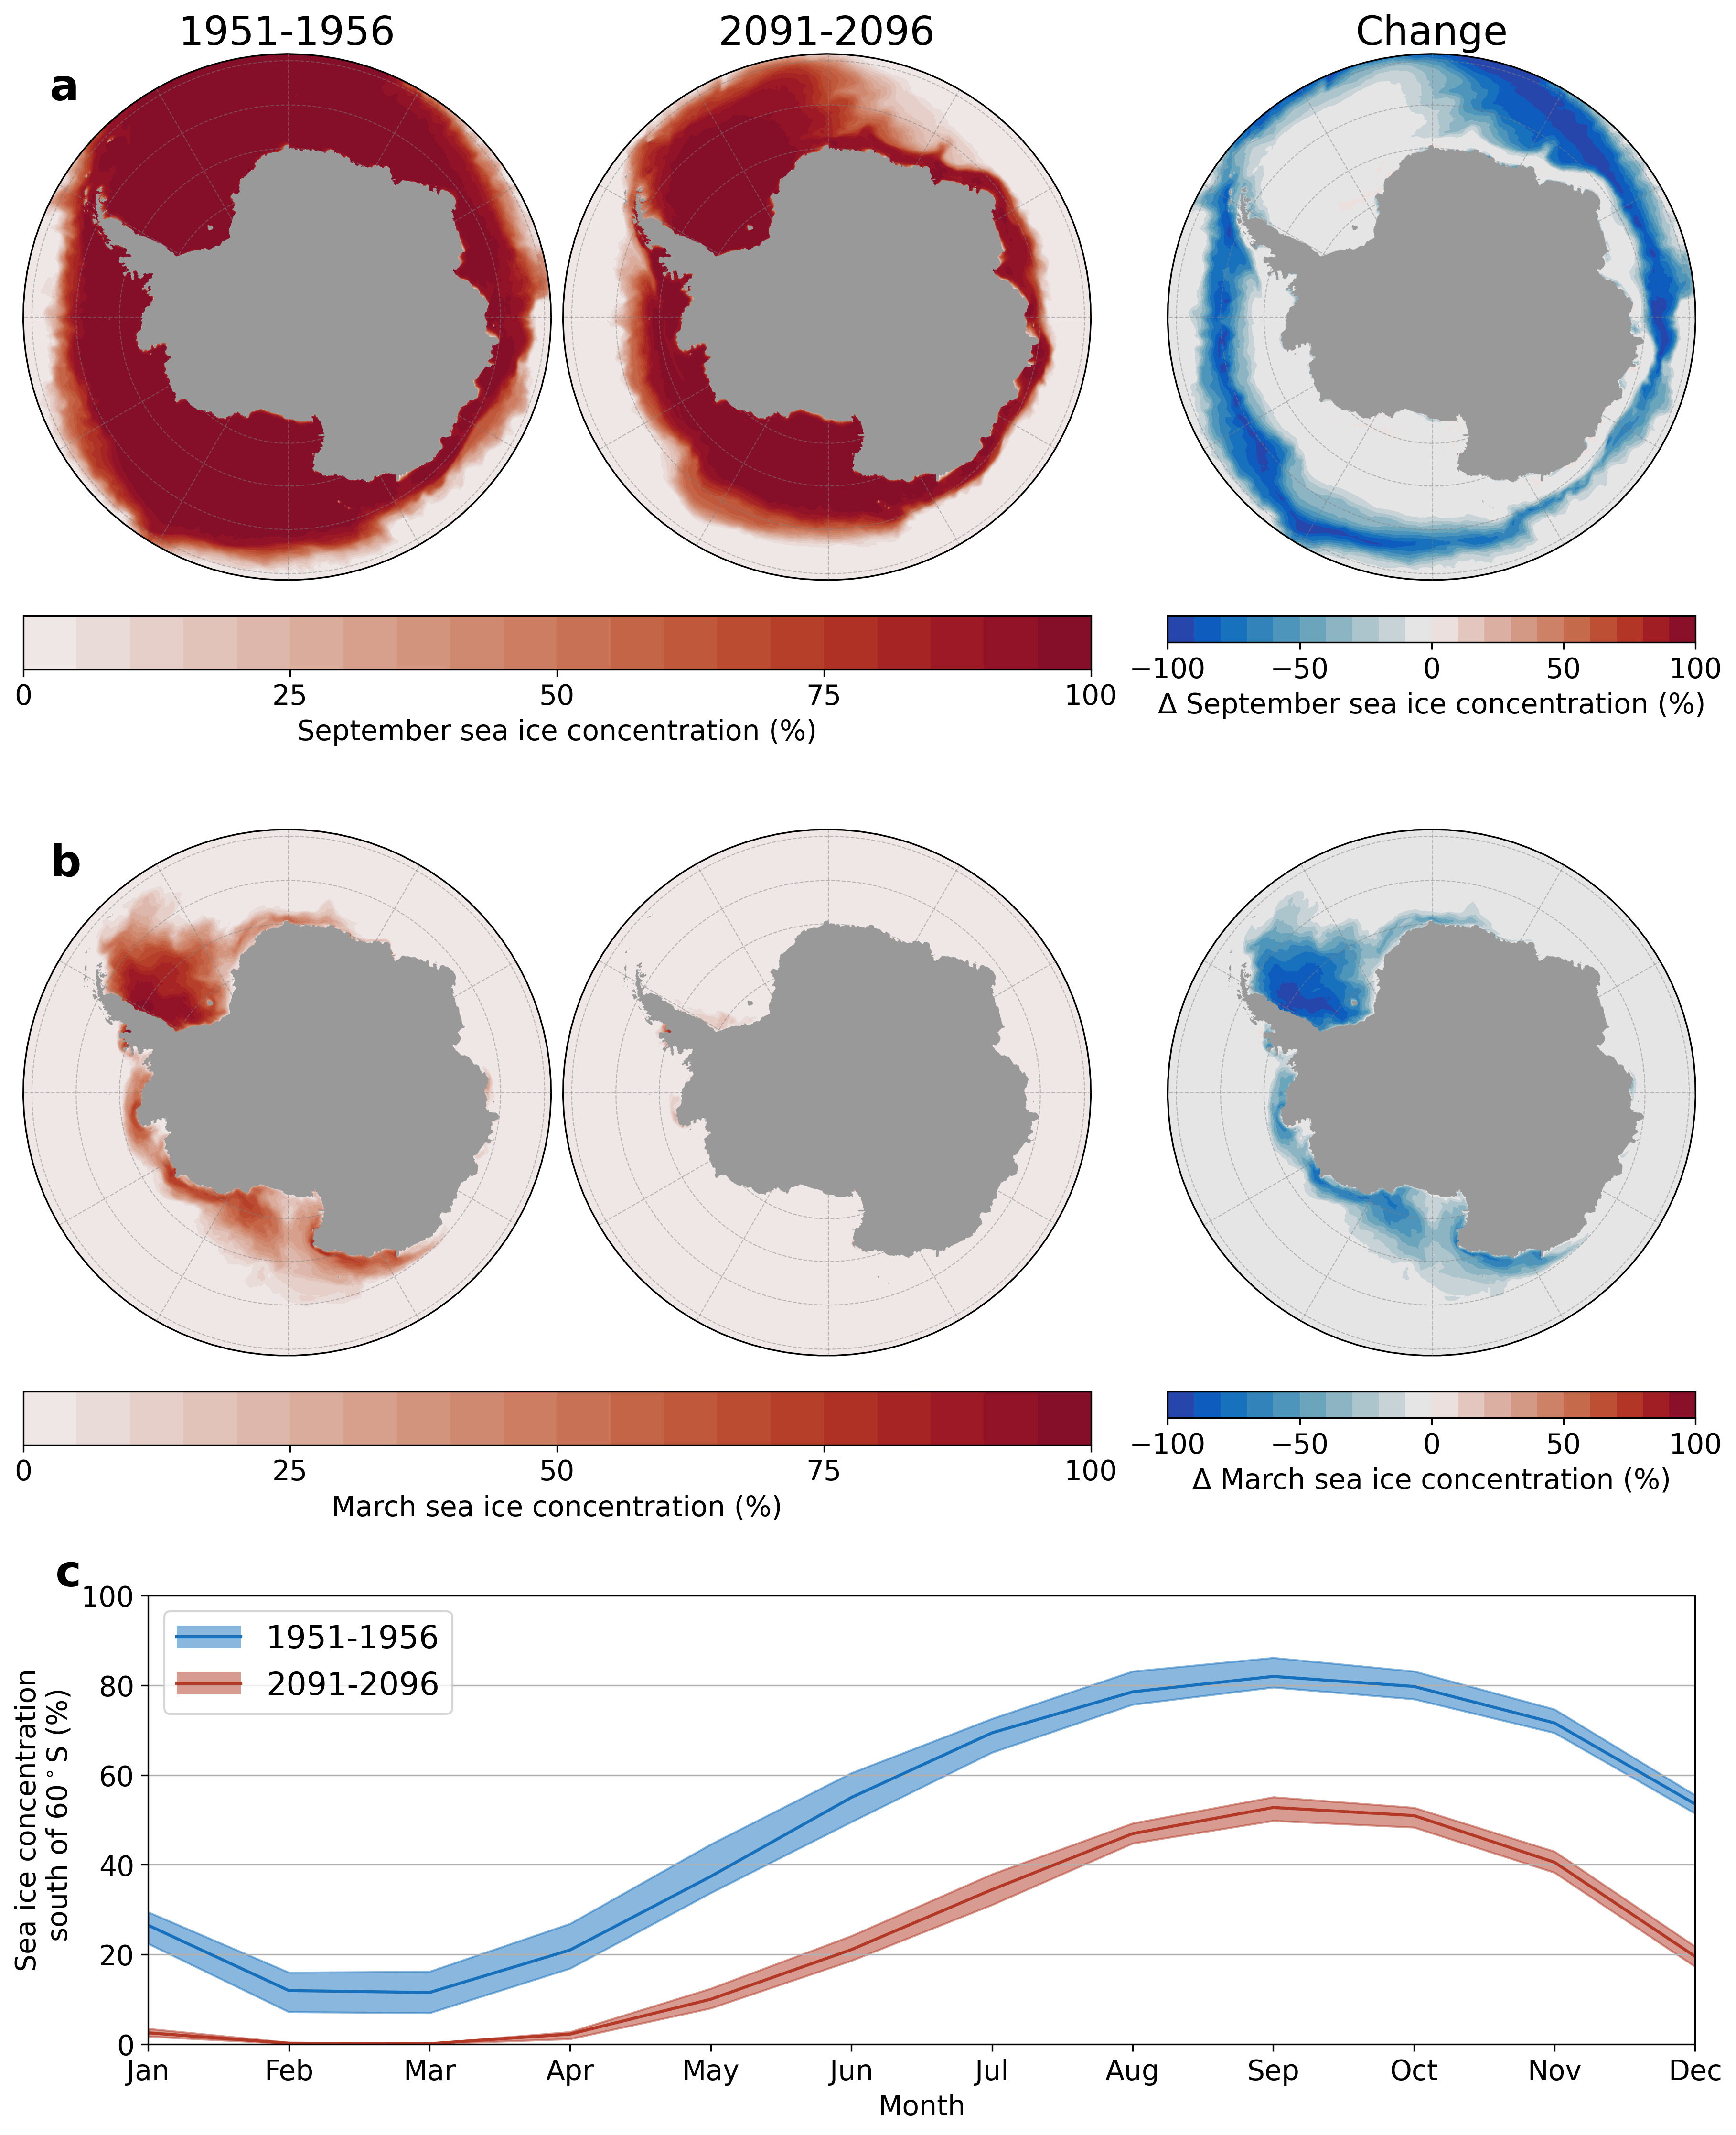

In [51]:
fig,axes=simple_plot(dpi=300,
                ygridlocs=[-80,-75,-70,-65,-60],
                figsize=(12,15),
                box=[-180,180,-80,-59],
                rows=3,
                cols=3)

#titles on first row
titlesize=20
axes[0,0].set_title('1951-1956',fontsize=titlesize)
axes[0,1].set_title('2091-2096',fontsize=titlesize)
axes[0,2].set_title('Change',fontsize=titlesize)

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('axes',labelsize=14)

#land mask
for ax in axes.flatten():
    ax.add_geometries(mesh.lsmask_p, crs=ccrs.PlateCarree(), 
                              facecolor=[0.6,0.6,0.6], edgecolor='none' ,linewidth=1,zorder=100)
for num,ax in enumerate(axes[:,0]):
    ax.annotate(labels[num], xy=(0.05, 0.9),xycoords='axes fraction',horizontalalignment='left', 
                     verticalalignment='bottom',fontsize=22,weight='bold')

# September ice concentration
cax_0=axes[0,0].contourf(xint,yint,sice50_int*100,levels=np.linspace(0,100,21),cmap=rm,transform=ccrs.PlateCarree())
axes[0,1].contourf(xint,yint,sice90_int*100,levels=np.linspace(0,100,21),cmap=rm,transform=ccrs.PlateCarree())
dax_0=axes[0,2].contourf(xint,yint,sice90_int*100-sice50_int*100,levels=np.linspace(-100,100,21),cmap=rbm,transform=ccrs.PlateCarree())

# row 4 colorbars
plt.colorbar(cax_0,ax=axes[0,:2],orientation='horizontal',label='September sea ice concentration (%)',ticks=[0,25,50,75,100])
plt.colorbar(dax_0,ax=axes[0,2],orientation='horizontal',label='Δ September sea ice concentration (%)',ticks=[-100,-50,0,50,100])

# March ice concentration
cax_1=axes[1,0].contourf(xint,yint,mice50_int*100,levels=np.linspace(0,100,21),cmap=rm,transform=ccrs.PlateCarree())
axes[1,1].contourf(xint,yint,mice90_int*100,levels=np.linspace(0,100,21),cmap=rm,transform=ccrs.PlateCarree())
dax_1=axes[1,2].contourf(xint,yint,mice90_int*100-mice50_int*100,levels=np.linspace(-100,100,21),cmap=rbm,transform=ccrs.PlateCarree())

# row 5 colorbars
plt.colorbar(cax_1,ax=axes[1,:2],orientation='horizontal',label='March sea ice concentration (%)',ticks=[0,25,50,75,100])
plt.colorbar(dax_1,ax=axes[1,2],orientation='horizontal',label='Δ March sea ice concentration (%)',ticks=[-100,-50,0,50,100])

#Sea ice monthly climatology
newax = plt.subplot2grid(shape=(9,3), loc=(7, 0), rowspan=2, colspan=3,)
dice0=newax.plot(monstrings,icemean50*100,color=mpl.cm.get_cmap(cmo.balance)(0.2))
dice0f=newax.fill_between(monstrings,icemin50*100,icemax50*100,color=mpl.cm.get_cmap(cmo.balance)(0.2),alpha=0.5,zorder=3)

dice1=newax.plot(monstrings,icemean90*100,color=mpl.cm.get_cmap(cmo.balance)(0.8))
dice1f=newax.fill_between(monstrings,icemin90*100,icemax90*100,color=mpl.cm.get_cmap(cmo.balance)(0.8),alpha=0.5,zorder=3)

newax.set_ylim(0,100)
newax.set_xlim(0,11)
newax.grid(axis='y')
newax.set_ylabel('Sea ice concentration\n south of 60$^\circ$S (%)')
newax.set_xlabel('Month')

legendfill0 = newax.fill([-3,-2], [0,1],linewidth=0, color=mpl.cm.get_cmap(cmo.balance)(0.2),alpha=0.5,label='1951-1956')
legendfill1 = newax.fill([-3,-2], [0,1],linewidth=0, color=mpl.cm.get_cmap(cmo.balance)(0.8),alpha=0.5,label='2091-2096')

newax.legend(loc='upper left',fontsize=16)
newax.legend(handles=[(legendfill0[0],dice0[0]),(legendfill1[0],dice1[0])],labels=['1951-1956','2091-2096'],loc='upper left',fontsize=16)

newax.annotate('c', xy=(-0.06, 1),xycoords='axes fraction',horizontalalignment='left', 
                     verticalalignment='bottom',fontsize=22,weight='bold')

plt.savefig(figpath+'fig5.png',bbox_inches='tight')